In [39]:
import pandas as pd
import numpy as np

In [40]:
train_data = pd.read_csv('./data/Kaggle_house_price/train.csv', index_col=0)
test_data = pd.read_csv('./data/Kaggle_house_price/test.csv', index_col=0)
train_data.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
ID,,,,,,,,,,,,,,
1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
2,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
5,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
7,0.08829,12.5,7.87,0,0.524,6.012,66.6,5.5605,5,311,15.2,395.60,12.43,22.9


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001FAAFFB0470>,
      dtype=object)

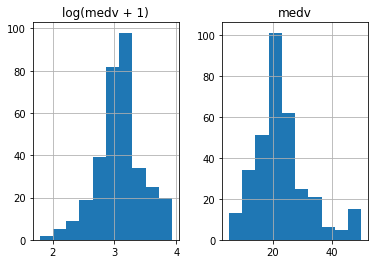

In [42]:
#这里先看看长什么样子，没有做处理
%matplotlib inline
prices = pd.DataFrame({"medv":train_data["medv"], "log(medv + 1)":np.log1p(train_data["medv"])})
prices.hist()

In [43]:
#将训练集的售价取出，方便接下来合并两个集合

y_train = np.log1p(train_data.pop('medv'))
#合并两个数据集
all_df = pd.concat((train_data, test_data), axis=0)
###看看合并后的结果
all_df.shape

(506, 13)

In [46]:
####Step 3: 变量转化
##类似『特征工程』。就是把不方便处理或者不unify的数据给统一了
###看数据的描述，明确数据的属性  有些数字可能只表示类别，我们需要区分一下
#MSSubClass 的值其实应该是一个category
all_df['tax'].dtypes
all_df['tax'] = all_df['tax'].astype(str)
all_df['tax'].value_counts()

666    132
307     40
403     30
437     15
304     14
264     12
398     12
277     11
384     11
330     10
224     10
233      9
432      9
276      9
296      8
193      8
287      8
391      8
222      7
284      7
311      7
188      7
270      7
300      7
329      6
254      5
289      5
216      5
711      5
273      5
      ... 
293      3
430      3
245      3
358      3
345      3
337      2
352      2
348      2
315      2
402      2
334      2
411      2
370      2
252      2
265      2
335      2
242      2
256      1
285      1
244      1
198      1
313      1
226      1
255      1
280      1
422      1
241      1
469      1
351      1
187      1
Name: tax, Length: 66, dtype: int64

In [47]:
#pandas自带的get_dummies方法，可以帮你一键做到One-Hot
pd.get_dummies(all_df['tax'], prefix='tax').head()
###把所有的是分类的数据都变成数值型形式，pandas的get_dummies函数会自动识别是类别的列，并转换成one-hot形式
all_dummy_df = pd.get_dummies(all_df)
all_dummy_df.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,ptratio,...,tax_402,tax_403,tax_411,tax_422,tax_430,tax_432,tax_437,tax_469,tax_666,tax_711
ID,,,,,,,,,,,,,,,,,,,,,
1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,15.3,...,0,0,0,0,0,0,0,0,0,0
2,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,17.8,...,0,0,0,0,0,0,0,0,0,0
4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,18.7,...,0,0,0,0,0,0,0,0,0,0
5,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,18.7,...,0,0,0,0,0,0,0,0,0,0
7,0.08829,12.5,7.87,0,0.524,6.012,66.6,5.5605,5,15.2,...,0,0,0,0,0,0,0,0,0,0


In [48]:
###处理好numerical变量（数字缺失）

##查看有哪些有缺失
all_dummy_df.isnull().sum().sort_values(ascending=False).head(10)
         ##看看怎么填充缺失值（平均值或者其他）


tax_711    0
tax_252    0
tax_233    0
tax_241    0
tax_242    0
tax_243    0
tax_244    0
tax_245    0
tax_247    0
tax_254    0
dtype: int64

In [ ]:
#求平均值
mean_cols = all_dummy_df.mean()
mean_cols.head(10)
#用平均值填充
all_dummy_df = all_dummy_df.fillna(mean_cols)


In [49]:
##看看还有没有缺失
all_dummy_df.isnull().sum().sum()

0

In [50]:
###标准化numerical数据

   ###先来看看 哪些是numerical的
numeric_cols = all_df.columns[all_df.dtypes != 'object']
numeric_cols

Index(['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad',
       'ptratio', 'black', 'lstat'],
      dtype='object')

In [51]:
#对数值类特征也进行均化处理
all_dummy_df.loc[:,numeric_cols] = np.log1p(all_dummy_df.loc[:,numeric_cols])

In [52]:
####Step 4: 建立模型
##11把数据集分回 训练/测试集
dummy_train_data = all_dummy_df.loc[train_data.index]
dummy_test_data = all_dummy_df.loc[test_data.index]
dummy_train_data.shape, dummy_test_data.shape

((333, 78), (173, 78))

In [61]:
##########模型构建
###把数据转成了numpy形式，方便处理
X_train = dummy_train_data.values
X_test = dummy_test_data.values
###Ridge
from sklearn.linear_model import Ridge   ##Ridge Regression模型会把所有的变量都放进分类器，给出结果
from sklearn.model_selection import cross_val_score

alphas = np.arange(2,4,0.1)
test_scores = []
for alpha in alphas:
    clf = Ridge(alpha)
    test_score = np.sqrt(-cross_val_score(clf, X_train, y_train, cv=10, scoring='neg_mean_squared_error'))
    test_scores.append(np.mean(test_score))
print('okok')

okok


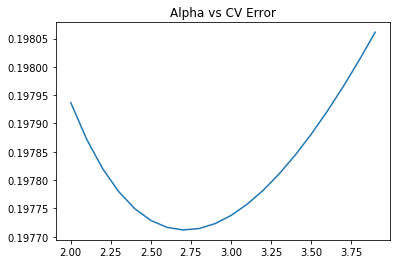

In [62]:
#存下所有的CV值，看看哪个alpha值更好（也就是『调参数』）
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(alphas, test_scores)
plt.title("Alpha vs CV Error");

In [ ]:
###8的时候比较好
#结果
ridge = Ridge(alpha = 2.7)

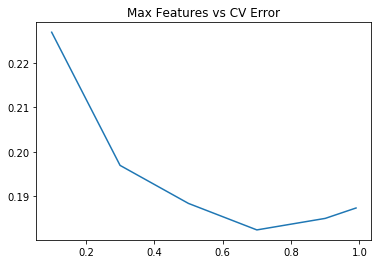

In [63]:
###Random Forest
from sklearn.ensemble import RandomForestRegressor
max_features = [.1, .3, .5, .7, .9, .99]
test_scores = []
for max_feat in max_features:
    clf = RandomForestRegressor(n_estimators=200, max_features=max_feat)
    test_score = np.sqrt(-cross_val_score(clf, X_train, y_train, cv=5, scoring='neg_mean_squared_error'))
    test_scores.append(np.mean(test_score))
    
plt.plot(max_features, test_scores)
plt.title("Max Features vs CV Error");

In [64]:
##Step 5: Ensemble  我们用一个Stacking的思维来汲取两种或者多种模型的优点
ridge = Ridge(alpha=2.7)
rf = RandomForestRegressor(n_estimators=500, max_features=.7)

ridge.fit(X_train, y_train)
rf.fit(X_train, y_train)
print('okokokok')

okokokok


In [65]:
##因为最前面我们给label做了个log(1+x), 于是这里我们需要把predit的值给exp回去，并且减掉那个"1"
##所以就是我们的expm1()函数。
y_ridge = np.expm1(ridge.predict(X_test))
y_rf = np.expm1(rf.predict(X_test))
print('111111111')

111111111


In [66]:
###一个正经的Ensemble是把这群model的预测结果作为新的input，再做一次预测。这里我们简单的方法，就是直接『平均化』
y_final = (y_ridge + y_rf) / 2
test_data.shape

(173, 13)

In [67]:
##Step 6: 提交结果
submission_df = pd.DataFrame(data= {'Id' : test_data.index, 'medv': y_final})
submission_df.head(10)
submission_df.to_csv("./data/Kaggle_house_price/submassion_predictions-1.csv", index=False)
print('over') 

over
